- Load CREMA-D

In [14]:
import os
import pandas as pd
import librosa
import numpy as np
import torchaudio
import speechbrain
from speechbrain.pretrained import SpeakerRecognition

df = pd.read_csv('/home/arnav/BTP/CREMA-D/VideoDemographics.csv')

"""
Load CREMA-D audio files and extract X-vectors
"""
audio_folder_path = '/home/arnav/BTP/CREMA-D/AudioWAV'

# Emotion mapping
emotion_map = {
    'ANG': 'Anger',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy/Joy',
    'NEU': 'Neutral',
    'SAD': 'Sad'
}

"""
Load X-vectors
"""
model = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="tmpdir")

def extract_x_vector(audio_path):
    signal, fs = torchaudio.load(audio_path)
    embeddings = model.encode_batch(signal)
    return embeddings.squeeze()

# List to hold the combined data
combined_data = []

for filename in os.listdir(audio_folder_path):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_folder_path, filename)
        # Extracting ActorID, emotion, and MFCCs
        parts = filename.split('_')
        actor_id, emotion_code = int(parts[0]), parts[2]
        mfccs = extract_x_vector(file_path)

        # Finding the corresponding row in the dataframe
        row = df[df['ActorID'] == actor_id].iloc[0]
        
        # Adding to the combined data list
        combined_data.append({
            'Filename': filename,
            'ActorID': actor_id,
            'Age': row['Age'],
            'Sex': row['Sex'],
            'Race': row['Race'],
            'Ethnicity': row['Ethnicity'],
            'Emotion': emotion_map[emotion_code],
            'X_Vec': mfccs
        })

# Creating a new DataFrame
combined_df = pd.DataFrame(combined_data)

# Display the first few rows of the combined DataFrame
print(combined_df.head())


              Filename  ActorID  Age   Sex              Race     Ethnicity  \
0  1083_IOM_NEU_XX.wav     1083   45  Male  African American  Not Hispanic   
1  1038_IWL_HAP_XX.wav     1038   21  Male  African American  Not Hispanic   
2  1001_WSI_ANG_XX.wav     1001   51  Male         Caucasian  Not Hispanic   
3  1016_MTI_SAD_XX.wav     1016   61  Male         Caucasian  Not Hispanic   
4  1038_MTI_HAP_XX.wav     1038   21  Male  African American  Not Hispanic   

     Emotion                                              X_Vec  
0    Neutral  [tensor(-22.1709), tensor(8.2183), tensor(9.26...  
1  Happy/Joy  [tensor(-28.3824), tensor(-7.3720), tensor(6.5...  
2      Anger  [tensor(-19.7765), tensor(-1.3577), tensor(10....  
3        Sad  [tensor(-21.2852), tensor(7.5706), tensor(5.01...  
4  Happy/Joy  [tensor(-22.4629), tensor(-7.9421), tensor(11....  


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Ensure X_Vec is in a suitable format for training
combined_df['X_Vec'] = combined_df['X_Vec'].apply(lambda x: x.numpy())

# Prepare the data for training
X = np.array(combined_df['X_Vec'].tolist())
y_emotion = combined_df['Emotion']
y_gender = combined_df['Sex']

In [25]:
emotion_dict = {
    'Neutral': 0,
    'Happy/Joy': 1, 
    'Anger': 2, 
    'Sad' : 3,
    'Disgust': 4 ,
    'Fear': 5
}
gender_dict ={
    'Male' : 0,
    'Female': 1
}

In [26]:
mapped_emotions = [emotion_dict[i] for i in y_emotion]

# Convert the mapped list into a numpy array
emotion_array = np.array(mapped_emotions)
unique_emotions = np.unique(emotion_array)

print(unique_emotions)

[0 1 2 3 4 5]


In [27]:
mapped_gender = [gender_dict[i] for i in y_gender]

# Convert the mapped list into a numpy array
gender_array = np.array(mapped_gender)
unique_genders = np.unique(gender_array)

print(unique_genders)

[0 1]


In [33]:
# Splitting the dataset into training and testing sets for emotion recognition
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, emotion_array, test_size=0.2, random_state=42)

# Splitting the dataset for gender recognition
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X, gender_array, test_size=0.2, random_state=42)

# Training the MLP classifier for emotion recognition
mlp_emotion = MLPClassifier(hidden_layer_sizes=(512,128), max_iter=300, random_state=42)
mlp_emotion.fit(X_train_e, y_train_e)

# Training the MLP classifier for gender recognition
mlp_gender = MLPClassifier(hidden_layer_sizes=(512,128), max_iter=300, random_state=42)
mlp_gender.fit(X_train_g, y_train_g)

# Predicting and evaluating for emotion recognition
y_pred_e = mlp_emotion.predict(X_test_e)
emotion_accuracy = accuracy_score(y_test_e, y_pred_e)
print(f"Emotion Recognition Accuracy: {emotion_accuracy}")

# Predicting and evaluating for gender recognition
y_pred_g = mlp_gender.predict(X_test_g)
gender_accuracy = accuracy_score(y_test_g, y_pred_g)
print(f"Gender Recognition Accuracy: {gender_accuracy}")


Emotion Recognition Accuracy: 0.6514439220953661
Gender Recognition Accuracy: 0.9932840832773674


In [9]:
combined_df.iloc[0]['X_Vec'].shape

(512,)

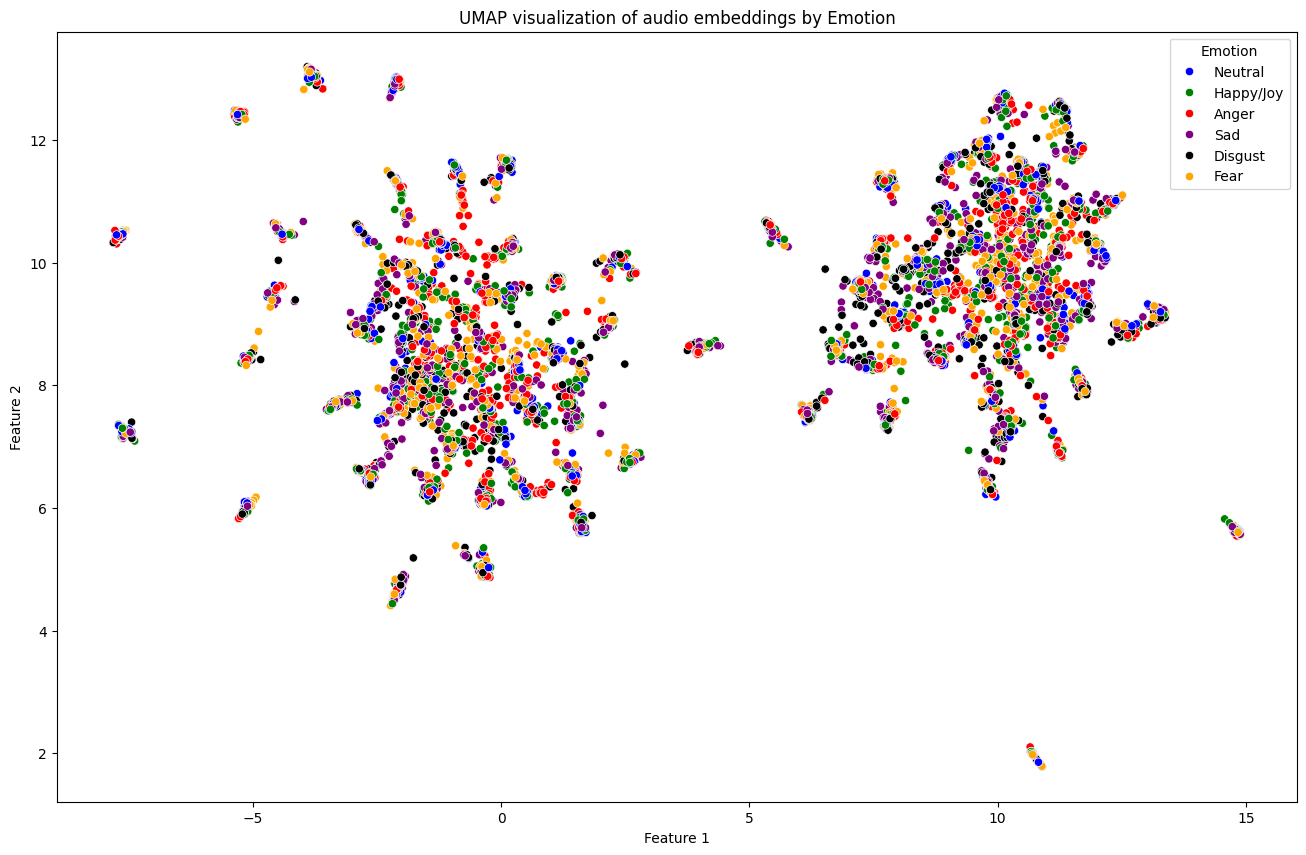

In [15]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming x_vectors is a NumPy array with your audio embeddings
# and combined_df is your DataFrame with the 'Emotion' column

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
X_2d_scaled = reducer.fit_transform(x_vectors)

# Convert UMAP output into a DataFrame for Seaborn
df = pd.DataFrame(X_2d_scaled, columns=['Feature1', 'Feature2'])
df['Emotion'] = combined_df['Emotion']

# Define custom colors for emotions
colors = {'Neutral': 'blue', 'Happy/Joy': 'green', 'Anger': 'red', 'Sad': 'purple', 'Disgust': 'black', 'Fear': 'orange'}

# Plot
plt.figure(figsize=(16, 10))
sns.scatterplot(x='Feature1', y='Feature2', data=df, hue='Emotion', palette=colors)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('UMAP visualization of audio embeddings by Emotion')
plt.show()


In [2]:
combined_df['X_Vec'] = combined_df['X_Vec'].apply(lambda x: x.numpy())

In [3]:
print(combined_df['X_Vec'])

0       [-22.170809, 8.2183, 9.26033, 5.5982504, 1.251...
1       [-28.382261, -7.3719926, 6.5264516, 5.4185367,...
2       [-19.776484, -1.3576446, 10.18596, 12.585467, ...
3       [-21.28527, 7.5706973, 5.0173817, 8.982029, -5...
4       [-22.46295, -7.942152, 11.375049, 4.487266, -1...
                              ...                        
7437    [-21.866953, 0.101776555, 15.380056, 11.802889...
7438    [-21.03274, -3.0762594, 8.931395, 2.8744216, -...
7439    [-19.762625, 4.9429245, 12.28647, 10.235459, 2...
7440    [-21.77075, 6.0592537, 10.300544, 8.797564, 4....
7441    [-15.577958, 3.1528301, 4.8651495, 7.2040386, ...
Name: X_Vec, Length: 7442, dtype: object


In [4]:
x_vectors = np.stack(combined_df['X_Vec'].values)
print(x_vectors)

[[-22.170809    8.2183      9.26033   ...  -4.308153    7.4036083
  -15.53562  ]
 [-28.382261   -7.3719926   6.5264516 ...  -0.4683745  11.31163
  -18.553864 ]
 [-19.776484   -1.3576446  10.18596   ...   3.5962172  11.860707
  -15.788083 ]
 ...
 [-19.762625    4.9429245  12.28647   ...  -1.977762   11.593661
  -12.792906 ]
 [-21.77075     6.0592537  10.300544  ...  -1.1395199   8.140986
  -12.152802 ]
 [-15.577958    3.1528301   4.8651495 ...  -6.023939    9.305772
  -11.367876 ]]


In [5]:
x_vectors = np.array(x_vectors)

print(x_vectors.shape)

(7442, 512)


In [6]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0)
X_2d = tsne_model.fit_transform(x_vectors)

In [7]:
print(X_2d.shape)

(7442, 2)


In [8]:
# Normalize the data using MinMaxScaler so that the values are between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_2d_scaled = scaler.fit_transform(X_2d)

/home/arnav/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x1000 with 0 Axes>

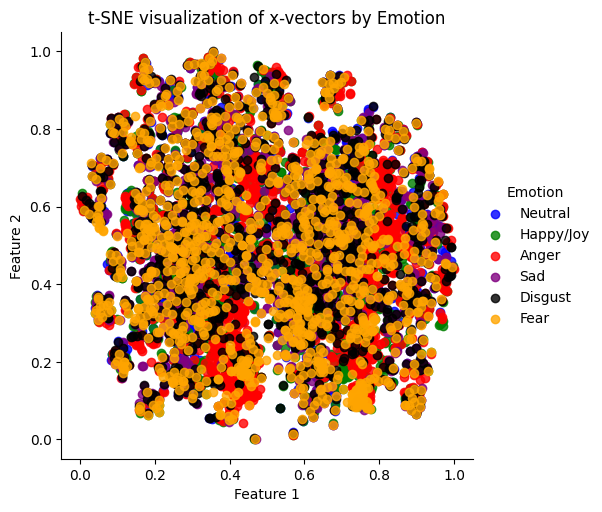

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming X_2d_scaled is defined and contains the 2D representation of your data
# And combined_df is your original DataFrame containing the 'Emotion' column

plt.figure(figsize=(16, 10))

# Convert your data into a DataFrame for Seaborn
df = pd.DataFrame(X_2d_scaled, columns=['Feature1', 'Feature2'])
df['Emotion'] = combined_df['Emotion']

# Define custom colors
colors = {'Neutral': 'blue', 'Happy/Joy': 'green', 'Anger': 'red', 'Sad': 'purple', 'Disgust': 'black', 'Fear': 'orange'}

# Plot
sns.lmplot(x='Feature1', y='Feature2', data=df, fit_reg=False, hue='Emotion', legend=True, palette=colors)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('t-SNE visualization of x-vectors by Emotion')
plt.show()


/home/arnav/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x1000 with 0 Axes>

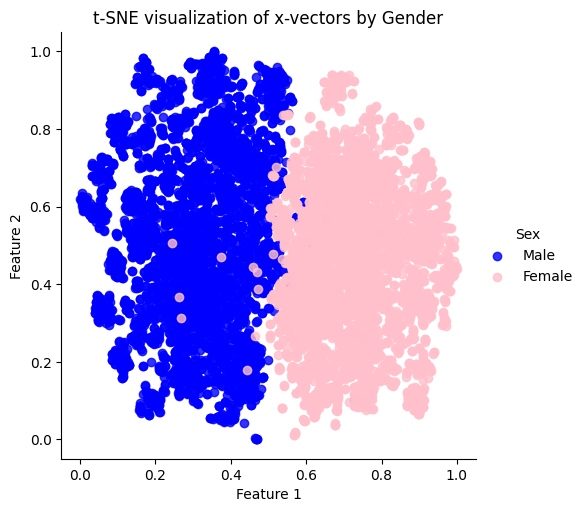

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming X_2d_scaled is defined and contains the 2D representation of your data
# And combined_df is your original DataFrame containing the 'Emotion' column

plt.figure(figsize=(16, 10))

# Convert your data into a DataFrame for Seaborn
df = pd.DataFrame(X_2d_scaled, columns=['Feature1', 'Feature2'])
df['Sex'] = combined_df['Sex']

# Define custom colors
colors = {'Male': 'blue','Female':'pink'}

# Plot
sns.lmplot(x='Feature1', y='Feature2', data=df, fit_reg=False, hue='Sex', legend=True, palette=colors)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('t-SNE visualization of x-vectors by Gender')
plt.show()


/home/arnav/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x1000 with 0 Axes>

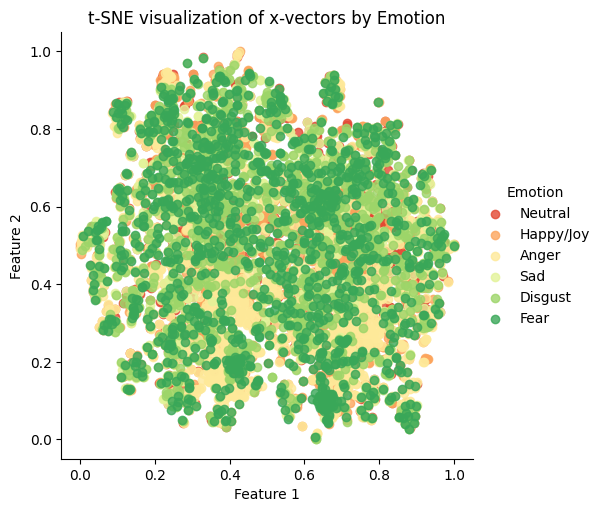

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(16, 10))

# Convert your data into a DataFrame for Seaborn
df = pd.DataFrame(X_2d_scaled, columns=['Feature1', 'Feature2'])
df['Emotion'] = combined_df['Emotion']

# Plot
sns.lmplot(x='Feature1', y='Feature2', data=df, fit_reg=False, hue='Emotion', legend=True, palette="RdYlGn")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('t-SNE visualization of x-vectors by Emotion')
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# colors = {'Anger': 'red', 'Disgust': 'orange', 'Fear': 'yellow', 'Happy/Joy': 'green', 'Neutral': 'blue', 'Sad': 'purple'}

# for x, y, emotion in zip(X_2d_scaled[:, 0], X_2d_scaled[:, 1], combined_df['Emotion']):
#     plt.scatter(x, y, color=colors[emotion], label=emotion, alpha=0.5)

# # # Set fixed axis limits
# plt.xlim([-50, 50])  # Adjust these values based on your t-SNE results
# plt.ylim([-50, 50])  # Adjust these values based on your t-SNE results

# plt.gca().set_aspect('equal', adjustable='box')

# plt.legend(loc='best', markerscale=1.5, title='Emotion')
# plt.xlabel('t-SNE feature 1')
# plt.ylabel('t-SNE feature 2')
# plt.title('t-SNE visualization of x-vectors categorized by emotion')
# plt.show()
